In [ ]:
!pip install -U pip wheel setuptools
!pip install concrete-ml

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [24]:
from numpy import mean
from numpy import std
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, roc_auc_score
from concrete.ml.sklearn import LogisticRegression, LinearRegression
from sklearn.linear_model import LogisticRegression as skLR
from sklearn.linear_model import LinearRegression as skLinear
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import time
import pandas as pd

start_time = time.time()
def feature_selection(x, opt = "", var_percent = 0.8, n_features = 30):
    if opt == "var":
        print("\nUsing variance threshold feature selection...")
        # Remove all features that have low variance in more than (percent)% of the samples.
        sel = VarianceThreshold(threshold=(var_percent * (1 - var_percent)))
        print("Shape of X: ", x.shape)
        x = sel.fit_transform(x)
        print("After feature selection: ", len(x[0]), " features")
        cols_idxs = sel.get_support(indices=True)
    elif opt == "kbest":
        print("\nUsing K best features feature selection...")
        print("Shape of x before selection: ", x.shape)
        sel = SelectKBest(chi2, k=n_features)
        x = sel.fit_transform(x, y)
        print("Shape of x after selection: ", x.shape)
        cols_idxs = sel.get_support(indices=True)
    elif opt == "pca":
        print("\nUsing PCA feature selection...")
        x_scaled = StandardScaler().fit_transform(x)
        pca = PCA(n_components=n_features)
        pca_features = pca.fit_transform(x_scaled)
        print('Shape before PCA: ', x_scaled.shape)
        print('Shape after PCA: ', pca_features.shape)
        x = pca_features
        cols_idxs = pca.get_support(indices=True)
    else:
        print("")
    return x, cols_idxs

#select set option
set = -1

dataset = pd.read_csv("DATASET (06-16-2023) Downsized and Includes Omicron Subvariants.csv")

#print(dataset['Lineage'].value_counts())

#remove "EPI_ISL_" from ID
#new_ID_col = []
#for i in range(0, len(dataset['Accession ID'])):
#    new_ID_col.append(str(dataset['Accession ID'].loc[i].replace("EPI_ISL_", "")))
#dataset['Accession ID'] = new_ID_col

feature_cols = [c for c in dataset.columns[2:]]
#print(feature_cols)

x = dataset.loc[:,feature_cols].values #must be floats
y = dataset.loc[:,'Lineage'].values #must be integers

#print(x)
#print(y)

# Preprocessing with labels for the lineage
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)
print(le.classes_)

x = x.astype(float)

print("Shape of x: ", x.shape)
print("Shape of y:", y.shape)

print(f"Running time is {time.time() - start_time} seconds")

['B.1.617.2' 'B.1.621' 'BA.1' 'BA.1.1' 'BA.1.17.2' 'BA.2' 'C.37']
Shape of x:  (3510, 512)
Shape of y: (3510,)
Running time is 0.16831755638122559 seconds


In [25]:
# Feature Selection Cell (ensemble attempted)

start_time = time.time()
#x = feature_selection(x, "var", var_percent = 0.80)
x, cols_idxs = feature_selection(x, "kbest", n_features = 15)
#x = feature_selection(x, "pca", n_features = 5)

# print(dataset.iloc[:,cols_idxs])

print("\nSelected features: ")
for col in cols_idxs:
    print(feature_cols[col])

print(f"Running time is {time.time() - start_time} seconds")


Using K best features feature selection...
Shape of x before selection:  (3510, 512)
Shape of x after selection:  (3510, 15)

Selected features: 
feature_24
feature_32
feature_65
feature_73
feature_76
feature_87
feature_126
feature_180
feature_195
feature_209
feature_324
feature_327
feature_407
feature_413
feature_448
Running time is 0.021334409713745117 seconds


In [26]:
# Retrieve train and test sets

def split(x,y):
    X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.30)

    return X_train, X_test, y_train, y_test

start_time = time.time()
X_train, X_test, y_train, y_test = split(x,y)

print(f"Test set size: {X_test.shape}")

print(f"Running time is {time.time() - start_time} seconds")
#st_x = StandardScaler()
#X_train = st_x.fit_transform(X_train)
#X_test = st_x.transform(X_test)

Test set size: (1053, 15)
Running time is 0.001722097396850586 seconds


In [27]:
results = []
print("Getting performance metrics for scikit-learn model (Plaintext)...")

for i in range(0,10):
    X_train, X_test, y_train, y_test = split(x,y)
    start_time = time.time()
    skmodel = skLR(C=1)
    skmodel.fit(X_train,y_train)
    y_pred_sklearn = skmodel.predict(X_test)
    results.append(f"{skmodel.score(X_test,y_test)*100}")

for r in results:
    print(f"{r}")
#print("Accuracy for sklearn: ", skmodel.score(X_test,y_test)*100,"%")
#print(f"Running time is {time.time() - start_time} seconds")

quantized_results = []
print("Getting performance metrics for Concrete-ML model (Quantized Plaintext)...")
for i in range(0,10):
    X_train, X_test, y_train, y_test = split(x,y)
    model = LogisticRegression(C=1)
    # Fit the model
    model.fit(X_train, y_train)

    start_time = time.time()
    # Run the predictions on non-encrypted data as a reference
    y_pred_clear = model.predict(X_test)

    quantized_results.append(f"{model.score(X_test,y_test) * 100}")
    # print("Accuracy rate for quantized plaintext:  ", model.score(X_test,y_test) * 100, "%")
    # print(f"Running time is {time.time() - start_time} seconds")

for r in quantized_results:
    print(f"{r}")

fhe_results = []
print("Getting performance metrics for Concrete-ML model (FHE)...")
#for i in range(0,10):
X_train, X_test, y_train, y_test = split(x,y)
model = LogisticRegression(C=1)
#Fit the model
model.fit(X_train, y_train)
#print("Compiling...")
model.compile(x)
#print("model compiled!")
y_pred_fhe = model.predict(X_test, fhe="execute")
fhe_results.append(f"{accuracy_score(y_test, y_pred_fhe) * 100}%")

for r in fhe_results:
    print(f"{r}")

Getting performance metrics for scikit-learn model (Plaintext)...
78.25261158594492
78.06267806267806
77.96771130104464
78.06267806267806
77.30294396961064
78.06267806267806
79.67711301044635
78.06267806267806
77.68281101614434
77.96771130104464
Getting performance metrics for Concrete-ML model (Quantized Plaintext)...
77.77777777777779
77.87274453941122
78.91737891737893
77.68281101614434
79.39221272554606
79.77207977207978
79.01234567901234
79.48717948717949
78.06267806267806
79.2022792022792
Getting performance metrics for Concrete-ML model (FHE)...
79.39221272554606%


In [6]:
# Get running time for training of models
print("Getting training time and number of iterations for scikit-learn model (Plaintext)...")
results = []

for i in range(0,10):
    start_time = time.time()
    X_train, X_test, y_train, y_test = split(x,y)
    skmodel = skLR(C=1)
    skmodel.fit(X_train,y_train)
    results.append(f"{time.time() - start_time}")

for r in results:
    print(f"{r}")

print("Getting training time and number of iterations for Concrete-ML model (Quantized Plaintext and FHE)...")
quantized_results = []

for i in range(0,10):
    X_train, X_test, y_train, y_test = split(x,y)
    model = LogisticRegression(C=1)
    start_time = time.time()
    model.fit(X_train, y_train)
    quantized_results.append(f"{time.time() - start_time}")

for r in quantized_results:
    print(f"{r}")

Getting training time and number of iterations for scikit-learn model (Plaintext)...
0.11774444580078125
0.11230659484863281
0.14333224296569824
0.07573723793029785
0.08454060554504395
0.07921242713928223
0.0741567611694336
0.08748960494995117
0.10050606727600098
0.08483648300170898
Getting training time and number of iterations for Concrete-ML model (Quantized Plaintext and FHE)...
0.11174917221069336
0.11341309547424316
0.1199955940246582
0.11184048652648926
0.12994861602783203
0.10836601257324219
0.1100301742553711
0.11449027061462402
0.11745142936706543
0.11955857276916504


In [ ]:
print("Getting running time for scikit-learn model (Plaintext)...")
results = []

for i in range(0,10):
    X_train, X_test, y_train, y_test = split(x,y)
    skmodel = skLR(C=1)
    skmodel.fit(X_train,y_train)
    start_time = time.time()
    y_pred_sklearn = skmodel.predict(X_test)
    results.append(f"{time.time() - start_time}")

for r in results:
    print(f"{r}")

print("Getting running time for Concrete-ML model (Quantized Plaintext)...")
quantized_results = []

for i in range(0,10):
    X_train, X_test, y_train, y_test = split(x,y)
    model = LogisticRegression(C=1)
    model.fit(X_train, y_train)
    start_time = time.time()
    y_pred_clear = model.predict(X_test)
    quantized_results.append(f"{time.time() - start_time}")

for r in quantized_results:
    print(f"{r}")

print("Getting running time for Concrete-ML model (FHE)...")
fhe_results = []

for i in range(0,10):
    X_train, X_test, y_train, y_test = split(x,y)
    model = LogisticRegression(C=1)
    model.fit(X_train, y_train)
    model.compile(x)
    start_time = time.time()
    y_pred_clear = model.predict(X_test)
    fhe_results.append(f"{time.time() - start_time}")

for r in fhe_results:
    print(f"{r}")

In [ ]:
# # Initialize model and fix the number of bits to used for quantization 

# model = LogisticRegression(C=1)

# # Fit the model
# model.fit(X_train, y_train)

# start_time = time.time()
# # Run the predictions on non-encrypted data as a reference
# y_pred_clear = model.predict(X_test)

# # Output (plaintext vs FHE):
# # print("In clear:  ", le.inverse_transform(y_pred_clear))
# # accuracy_score(y_test, y_pred_clear)
# print("Accuracy rate for quantized plaintext:  ", model.score(X_test,y_test) * 100, "%")
# print(f"Running time is {time.time() - start_time} seconds")

# #low/higly volatile accuracy may be attributed to small dataset and too many features 
# #(feature selection needed and more samples are required)
# print("PREDICTION:\n", y_pred_clear)
# print("ACTUAL:\n", y_test) 

# # Compile into a FHE model
# start_time = time.time()
# print("Compiling...")
# model.compile(x)
# print("model compiled!")
# print(f"Running time is {time.time() - start_time} seconds")

# # Run the inference in FHE
# start_time = time.time()
# print("Predicting in FHE...")
# y_pred_fhe = model.predict(X_test, fhe="execute")
# print("Accuracy rate for FHE:  ", accuracy_score(y_test, y_pred_fhe) * 100, "%")

# #print("In FHE    :", y_pred_fhe)
# print(f"Comparison: {int((y_pred_fhe == y_pred_clear).sum()/len(y_pred_fhe)*100)}% similar")
# print(f"Running time is {time.time() - start_time} seconds")

In [28]:
#Get AUC for multiclass
#NOTE WE HAVE A MULTICLASS BUT NOT MULTILABEL PROBLEM. only one label selected from multiple classes is assigned
start_time = time.time()
results = []
quantized_results = []
fhe_results = []

print("Getting performance metrics for scikit-learn model (Plaintext)...")
for i in range(0,10):
    X_train, X_test, y_train, y_test = split(x,y)
    #start_time = time.time()
    skmodel = skLR(C=1)
    skmodel.fit(X_train,y_train)
    results.append(roc_auc_score(y, skmodel.predict_proba(x), multi_class='ovr'))

for r in results:
    print(f"{r}")

print("Getting performance metrics for Concrete-ML model (Quantized Plaintext)...")
for i in range(0,10):
    X_train, X_test, y_train, y_test = split(x,y)
    model = LogisticRegression(C=1)
    # Fit the model
    model.fit(X_train, y_train)
    quantized_results.append(roc_auc_score(y, model.predict_proba(x), multi_class='ovr'))

for r in quantized_results:
    print(f"{r}")

print("Getting performance metrics for Concrete-ML model (FHE)...")
# for i in range(0,10):
X_train, X_test, y_train, y_test = split(x,y)
model = LogisticRegression(C=1)
# Fit the model
model.fit(X_train, y_train)
#print("Compiling...")
model.compile(x)
fhe_results.append(roc_auc_score(y, model.predict_proba(x), multi_class='ovr'))

for r in fhe_results:
    print(f"{r}")

#print("Scikit learn ROC AUC Score (One vs Rest): ", roc_auc_score(y, skmodel.predict_proba(x), multi_class='ovr'))
#print("Scikit learn AUROC (One vs One): ", roc_auc_score(y, skmodel.predict_proba(x), multi_class='ovo'))
#print("Macro-averaged Concrete-ML ROC AUC Score (One vs Rest): ", roc_auc_score(y, model.predict_proba(x), multi_class='ovr'))
#print("Concrete-ML AUROC (One vs One): ", roc_auc_score(y, model.predict_proba(x), multi_class='ovo'))
#print(f"Running time is {time.time() - start_time} seconds")

Getting performance metrics for scikit-learn model (Plaintext)...
0.9570068186900652
0.9569986179345182
0.9572994005482035
0.9573880101025128
0.9570864263014845
0.9578212129330133
0.9572815816595729
0.9570979333830981
0.9572901310787422
0.9577953869736415
Getting performance metrics for Concrete-ML model (Quantized Plaintext)...
0.9569132099980818
0.9574386934693916
0.9563845451795773
0.9566326154898329
0.9573673434692314
0.9569372800706963
0.9570144854787518
0.9569056164706885
0.9573760890682931
0.9566662841637219
Getting performance metrics for Concrete-ML model (FHE)...
0.957190362286954


***Note: The diagonal elements are the correctly predicted samples. ***
Confusion matrix for SKLearn Plaintext: 


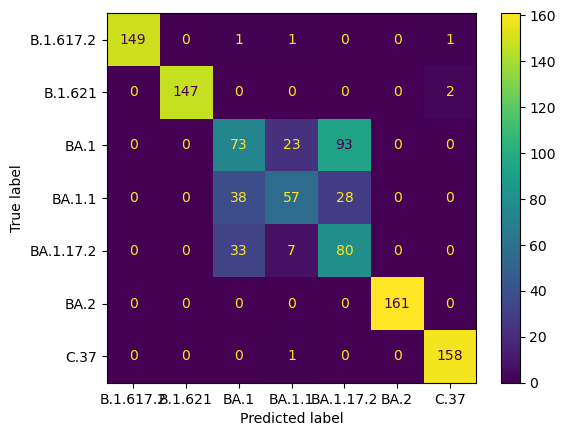

Confusion matrix for Quantized Plaintext: 


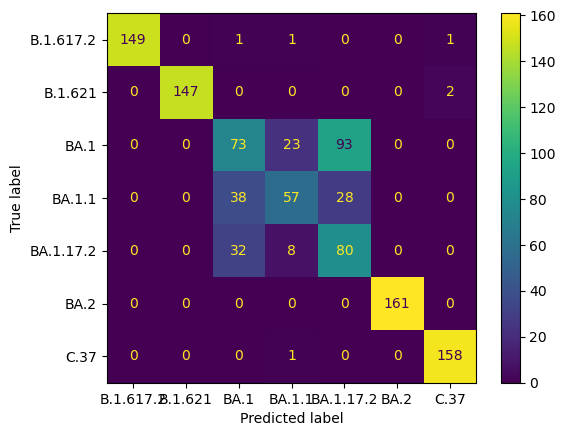

Confusion matrix for FHE: 


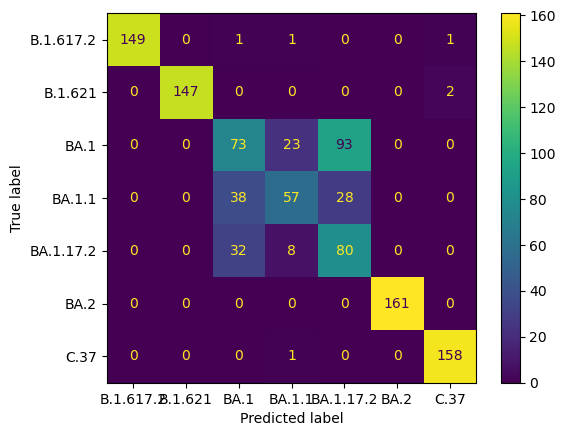

Running time is 2.0493762493133545 seconds
Comparison (FHE vs Plaintext): 99% similar
Comparison (FHE vs Quantized Plaintext): 100% similar


In [29]:
# In[10]:
start_time = time.time()

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print("***Note: The diagonal elements are the correctly predicted samples. ***")

#use the scikit-learn classes because we use the same class naman
X_train, X_test, y_train, y_test = split(x,y)

print("Confusion matrix for SKLearn Plaintext: ")
#print(confusion_matrix(y_test, y_pred_sklearn), "\n")
skmodel = skLR(C=1)
skmodel.fit(X_train,y_train)
y_pred_sklearn = skmodel.predict(X_test)
sklearn_cm_display = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_sklearn), display_labels=le.classes_)
sklearn_cm_display.plot()
plt.show()

print("Confusion matrix for Quantized Plaintext: ")
#print(confusion_matrix(y_test, y_pred_clear), "\n")
model = LogisticRegression(C=1)
model.fit(X_train,y_train)
y_pred_clear = model.predict(X_test)
concrete_plain_display = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_clear), display_labels=le.classes_)
concrete_plain_display.plot()
plt.show()

print("Confusion matrix for FHE: ")
#print(confusion_matrix(y_test, y_pred_fhe))
model.compile(x)
y_pred_fhe = model.predict(X_test)
concrete_fhe_display = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_fhe), display_labels=le.classes_)
concrete_fhe_display.plot()
plt.show()

print(f"Running time is {time.time() - start_time} seconds")

print(f"Comparison (FHE vs Plaintext): {int((y_pred_fhe == y_pred_sklearn).sum()/len(y_pred_fhe)*100)}% similar")
print(f"Comparison (FHE vs Quantized Plaintext): {int((y_pred_fhe == y_pred_clear).sum()/len(y_pred_fhe)*100)}% similar")

In [30]:
from concrete.ml.sklearn.svm import LinearSVC
from sklearn.svm import LinearSVC as skSVC
from concrete.ml.sklearn.rf import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier as skRF

print(f"Sklearn Accuracy (Linear Reg, RF, SVC):")

for i in range(0,10):
    X_train, X_test, y_train, y_test = split(x,y)

    #SKLEARN LINEAR REGRESSION
    skmodel2 = skLinear()
    skmodel2.fit(X_train,y_train)
    skmodel2.predict(X_test)
    #print("Sklearn Linear Regression Accuracy: ", skmodel2.score(X_test,y_test)*100,"%")

    #SKLEARN RANDOM FOREST
    skmodel3 = skRF()
    skmodel3.fit(X_train, y_train)
    skmodel3.predict(X_test)
    #print("Sklearn Random Forest Accuracy: ",skmodel3.score(X_test,y_test)*100,"%")

    #SKLEARN SVC
    skmodel4 = skSVC()
    skmodel4.fit(X_train, y_train)
    skmodel4.predict(X_test)
    #print("Sklearn SVC Accuracy: ",skmodel4.score(X_test,y_test)*100,"%")

    print(f"{skmodel2.score(X_test,y_test)*100} {skmodel3.score(X_test,y_test)*100} {skmodel4.score(X_test,y_test)*100}")

print(f"Concrete-ML Accuracy (Linear Reg, RF, SVC):")

for i in range(0,10):
    X_train, X_test, y_train, y_test = split(x,y)
    model2 = LinearRegression()
    model2.fit(X_train,y_train)
    model2.predict(X_test)
    #print("Concrete-ML Linear Regression Accuracy: ", model2.score(X_test,y_test)*100,"%")

    model3 = RandomForestClassifier()
    model3.fit(X_train, y_train)
    model3.predict(X_test)
    #print("Concrete-ML Random Forest Accuracy: ",model3.score(X_test,y_test)*100,"%")

    model4 = LinearSVC()
    model4.fit(X_train, y_train)
    model4.predict(X_test)
    #print("Concrete-ML SVC Accuracy: ",model4.score(X_test,y_test)*100,"%")

    print(f"{model2.score(X_test,y_test)*100}   {model3.score(X_test,y_test)*100}   {model4.score(X_test,y_test)*100}")

Sklearn Accuracy (Linear Reg, RF, SVC):
88.07773771347873 78.8224121557455 77.68281101614434
89.55569741436031 78.91737891737893 74.92877492877493
88.81426615412394 77.39791073124407 76.35327635327636
88.44864216368681 78.8224121557455 74.07407407407408
88.53427045037066 78.8224121557455 78.34757834757835
86.17536073962914 78.91737891737893 77.39791073124407
90.29035458442567 79.01234567901234 78.63247863247864
89.02083085298163 77.96771130104464 77.39791073124407
89.05068111089784 77.68281101614434 70.84520417853751
88.3259916448684 76.44824311490979 70.27540360873694
Concrete-ML Accuracy (Linear Reg, RF, SVC):
89.36130820395063   79.67711301044635   79.86704653371321
88.97662925430885   78.72744539411207   77.01804368471035
89.35577364022244   79.10731244064577   79.58214624881292
89.75426503530703   79.29724596391263   75.30864197530865
90.66390769095142   80.24691358024691   79.77207977207978
90.07204683644383   79.77207977207978   79.2022792022792
89.18250758299124   79.2972459639

In [ ]:
# In[10]:


#Attempting to save the model
from concrete.ml.deployment import FHEModelClient, FHEModelDev, FHEModelServer

start_time = time.time()

fhemodel_dev = FHEModelDev("./concrete-covid-classifier", model)
fhemodel_dev.save()

print(f"Running time for saving the FHE model is {time.time() - start_time} seconds")

In [ ]:
#Saving Scikit-learn model
from joblib import dump, load

dump(skmodel, './scikit-learn-classifier/scikitlearnmodel.joblib')
#loaded_model = load('scikitlearnmodel.joblib')